#### Purpose of the notebook
The code retrieves GDP forecasts from the European Central Bank (ECB).

1. **Initialize Data**: Set up lists of time periods and countries.
2. **Generate Combinations**: Create combinations of periods and countries for data retrieval.
3. **ECB Data Request Setup**: Prepare for data requests from the ECB.
4. **Data Retrieval Loop**: Iterate through each combination, fetching and processing data:
   - Retrieve data for each period-country pair.
   - Process and format the retrieved data.
   - Consolidate the data into a comprehensive DataFrame.
5. **Create scatterplots with forecasts and actual results**: Create necessary lags
6. **Display Results**: Create charts


Source: https://data.ecb.europa.eu/data/datasets/MPD/structure

| Item | Concept Description | Concept | Code List | Values |
|------|---------------------|---------|-----------|--------|
| 1.   | Frequency            | FREQ    | CL_FREQ   | A - Annual |
| 2.   | Reference area       | REF_AREA| CL_AREA_EE| Country code|
| 3.   | Projection database item | PD_ITEM | CL_PD_ITEM | PCU - Price and cost developments |
| 4.   | Series denominat/spec calcul | SERIES_DENOM | CL_SERIES_DENOM_PD | A - Annual growth rate |
| 5.   | Projection database season exercise | PD_SEAS_EX | CL_PD_SEAS_EX | A - Autumn, G - Spring |
| 6.   | Projection database data origin | PD_ORIGIN | CL_PD_ORIGIN | 0000 - Finalised/latest data |

In [1]:
import pandasdmx as sdmx
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Settings
pd.set_option('display.max_rows', None)

In [2]:
# Create required combinations
periods = [f"A{str(i).zfill(2)}" for i in range(1, 23)]
countries = ['DE', 'FR', 'NL']
combinations = list(itertools.product(periods, countries))

# Create a request instance for the ECB
ecb = sdmx.Request('ECB')
dataflow_id = 'MPD'

# Container for results
results = pd.DataFrame()

for a, b in combinations:
    # print(a, b)
    series_key = f'A.{b}.YER.A.{a}.0000'

    # Retrieve the data
    data_response = ecb.data(dataflow_id, key=series_key)
    df = data_response.to_pandas().reset_index()

    # Splitting the 'Code' into two columns: 'Season' and 'Year'
    df['Season'] = df['PD_SEAS_EX'].str[0]
    df['Forecast_year'] = '20' + df['PD_SEAS_EX'].str[1:]
    
    # Mapping seasons to their full names
    season_map = {'A': 'Autumn', 'B': 'Winter', 'C': 'Spring', 'D': 'Summer'}
    df['Season'] = df['Season'].map(season_map)
    
    df['Forecast_year'] = df['Forecast_year'].astype(int)
    df['TIME_PERIOD'] = df['TIME_PERIOD'].astype(int)
    
    # Update 'Type' column to compare 'Year' with 'TIME_PERIOD' within the same row
    df['Type'] = df.apply(lambda row: f'Forecast_{row["TIME_PERIOD"] - row["Forecast_year"]}_Y' 
                          if row["Forecast_year"] < row['TIME_PERIOD'] else 'Actual', axis=1)
    df['Type'] = np.where(df['TIME_PERIOD'] == df['Forecast_year'], 'Estimate', df['Type'])

    results = pd.concat([results, df], axis=0)



In [3]:
# Add a column with the actual value lagged by 1 year
df2 = results[['Forecast_year', 'TIME_PERIOD', 'value', 'Type', 'REF_AREA']].copy()
df2['TIME_PERIOD'] = df2['TIME_PERIOD']
df2['Forecast_year'] = df2['Forecast_year'] - 2
merged_df = pd.merge(results, df2[df2['Type'] == 'Actual'], 
                     on=['Forecast_year', 'TIME_PERIOD', 'REF_AREA'], 
                     suffixes=('', '_actual'), 
                     how='left')

# Append realised outcomes to forecasts
df2 = results[['Forecast_year', 'TIME_PERIOD', 'value', 'Type', 'REF_AREA']].copy()
df2['TIME_PERIOD'] = df2['TIME_PERIOD'] + 1
df2['Forecast_year'] = df2['Forecast_year'] - 2
merged_df = pd.merge(merged_df, df2[df2['Type'] == 'Actual'], 
                     on=['Forecast_year', 'TIME_PERIOD', 'REF_AREA'], 
                     suffixes=('', '_actual_1y_ago'), 
                     how='left')

# Calculate error
merged_df['abs_error'] = abs(merged_df['value'] - merged_df['value_actual'])

# Show the outcomes
merged_df[(merged_df['REF_AREA'] == 'DE') & (merged_df['TIME_PERIOD'] >2015)].tail(5)

,FREQ,REF_AREA,PD_ITEM,SERIES_DENOM,PD_SEAS_EX,PD_ORIGIN,TIME_PERIOD,value,Season,Forecast_year,Type,value_actual,Type_actual,value_actual_1y_ago,Type_actual_1y_ago,abs_error
1149,A,DE,YER,A,A22,0000,2021,2.6,Autumn,2022,Actual,NaN,NaN,NaN,NaN,NaN
1150,A,DE,YER,A,A22,0000,2022,1.8,Autumn,2022,Estimate,NaN,NaN,NaN,NaN,NaN
1151,A,DE,YER,A,A22,0000,2023,-0.5,Autumn,2022,Forecast_1_Y,NaN,NaN,NaN,NaN,NaN
1152,A,DE,YER,A,A22,0000,2024,1.7,Autumn,2022,Forecast_2_Y,NaN,NaN,NaN,NaN,NaN
1153,A,DE,YER,A,A22,0000,2025,1.4,Autumn,2022,Forecast_3_Y,NaN,NaN,NaN,NaN,NaN


<Figure size 3000x1800 with 0 Axes>

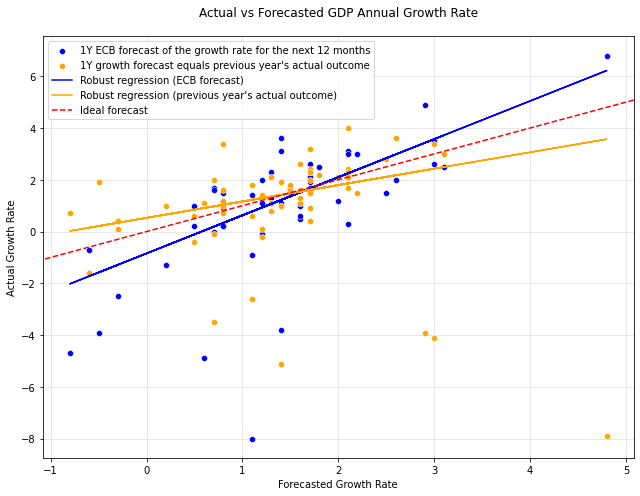

In [4]:
# Filters
idx_1 = merged_df['REF_AREA'] != 'SDE'
idx_2 = merged_df['TIME_PERIOD'] > 2001
idx_3 = merged_df['Type'] == 'Forecast_1_Y'

plot_df = merged_df[idx_1 & idx_2 & idx_3].copy()

# Check and handle NaNs and Infs
plot_df.replace([np.inf, -np.inf], np.nan, inplace=True)
plot_df.dropna(inplace=True)

x = plot_df['value']
y1 = plot_df['value_actual']
y2 = plot_df['value_actual_1y_ago']

# Creating the plot
plt.figure(figsize=(10, 6), dpi=300);
fig, ax = plt.subplots(figsize=(9, 7))

# Setting gridlines behind plot elements
ax.set_axisbelow(True)
ax.grid(True, linestyle='-', linewidth=0.5, color='lightgray', zorder=0)

# Scatter plot for actual data
sns.scatterplot(x=x, y=y1, ax=ax, color='blue', label='1Y ECB forecast of the growth rate for the next 12 months')
sns.scatterplot(x=x, y=y2, ax=ax, color='orange', label="1Y growth forecast equals previous year's actual outcome")

# Adding a robust regression line for y1
X = sm.add_constant(x)
model_robust_y1 = sm.RLM(y1, X, M=sm.robust.norms.HuberT()).fit()
y_pred_robust_y1 = model_robust_y1.predict(X)
ax.plot(x, y_pred_robust_y1, color='blue', label='Robust regression (ECB forecast)')

# Adding a robust regression line for y2
model_robust_y2 = sm.RLM(y2, X, M=sm.robust.norms.HuberT()).fit()
y_pred_robust_y2 = model_robust_y2.predict(X)
ax.plot(x, y_pred_robust_y2, color='orange', label="Robust regression (previous year's actual outcome)")

# Use the range of the data points for plotting the 45-degree line
data_min_val = min(plot_df['value'].min(), plot_df['value_actual'].min(), plot_df['value_actual_1y_ago'].min())
data_max_val = max(plot_df['value'].max(), plot_df['value_actual'].max(), plot_df['value_actual_1y_ago'].max())
ax.plot([data_min_val, data_max_val], [data_min_val, data_max_val], color='red', linestyle='--', label='Ideal forecast')

# Calculate the min and max for x and y, including predictions
all_x = np.concatenate([x, x])  # x is the same for both sets of y-values
all_y = np.concatenate([y1, y2, y_pred_robust_y1, y_pred_robust_y2])

min_x, max_x = all_x.min(), all_x.max()
min_y, max_y = all_y.min(), all_y.max()

# Define margins as a percentage of the range
margin_x = (max_x - min_x) * 0.05  # 5% margin
margin_y = (max_y - min_y) * 0.05  # 5% margin

# Set xlim and ylim with margins
ax.set_xlim((min_x - margin_x, max_x + margin_x))
ax.set_ylim((min_y - margin_y, max_y + margin_y))

# Setting titles and labels
ax.set_title('Actual vs Forecasted GDP Annual Growth Rate', pad=20)
ax.set_xlabel('Forecasted Growth Rate')
ax.set_ylabel('Actual Growth Rate')
ax.grid(True, linestyle='-', linewidth=0.5, color='lightgray')
ax.legend()

plt.tight_layout()

plt.savefig('forecast_vs_actual_gdp_growth.pdf', format='pdf')

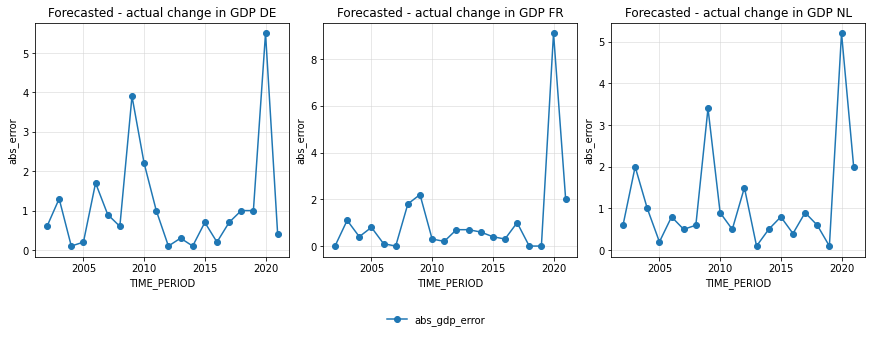

In [5]:
# Create error plots for individual countries
plot_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Unique reference areas for subplotting
ref_areas = plot_df['REF_AREA'].unique()
n_areas = len(ref_areas)

fig, axs = plt.subplots(nrows=1, ncols=n_areas, figsize=(4*n_areas, 4), constrained_layout=True)

# If only one area, axs may not be an array, so we ensure it's iterable
if n_areas == 1:
    axs = np.array([axs])

for ax, ref_area in zip(axs, ref_areas):
    # Filter the DataFrame for the current reference area
    df_filtered = plot_df[plot_df['REF_AREA'] == ref_area]
    
    # Plotting
    ax.plot(df_filtered['TIME_PERIOD'], df_filtered['abs_error'], marker="o", linestyle="-")
    
    # Adding gridlines
    ax.grid(True, linestyle='-', linewidth=0.5, color='lightgray')
    
    # Setting the title for each subplot
    ax.set_title(f'Forecasted - actual change in GDP {ref_area}')
    
    # If you need to set the same x and y labels for each subplot, do it here
    ax.set_xlabel('TIME_PERIOD')
    ax.set_ylabel('abs_error')

# Adjust layout to make room for the legend and ensure no overlap
fig.legend(['abs_gdp_error'], loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.show()

In [6]:
# Create error plots for individual countries
pd.options.display.float_format = '{:,.2f}'.format

# Filters
idx_1 = merged_df['Type'] == 'Forecast_1_Y'
idx_2 = merged_df['TIME_PERIOD'] > 2010

# Create pivot
pivot_df = merged_df[idx_1 & idx_2].pivot_table(index='TIME_PERIOD', columns='REF_AREA', values='abs_error', aggfunc='mean')
pivot_df

REF_AREA,DE,FR,NL
TIME_PERIOD,,,
2011,1.00,0.20,0.50
2012,0.10,0.70,1.50
2013,0.30,0.70,0.10
2014,0.10,0.60,0.50
2015,0.70,0.40,0.80
2016,0.20,0.30,0.40
2017,0.70,1.00,0.90
2018,1.00,0.00,0.60
2019,1.00,0.00,0.10
